In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# always useful
import numpy as np

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
mu, sigma = 0, 0.1 # mean and standard deviation
x = np.random.normal(mu, sigma, 1000)

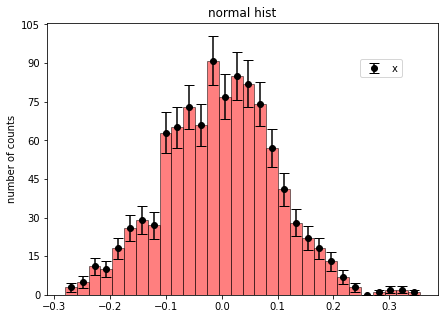

In [3]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(7, 5))
n, bins, _ = plt.hist(x, 30, alpha=0.5, ec='black', color='red')
mid = 0.5*(bins[1:] + bins[:-1])
ax.errorbar(mid, n, yerr=np.sqrt(n), fmt='ko', capsize=5, label='x')
#ax.hist(s, bins=30, label='x')
ax.set_ylabel('number of counts')
ax.legend(loc=(0.8, 0.8))
ax.set_title('normal hist')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

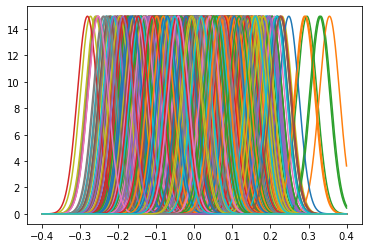

In [4]:
from scipy.stats import norm

std = 1.06 * x.std() * x.size**(-1/5)
t = np.arange(-0.4, 0.4, 0.0001)
f = np.array([norm.pdf(t, x[i], std) for i in range(len(x))])

for i in range(len(x)):
    plt.plot(t,f[i])

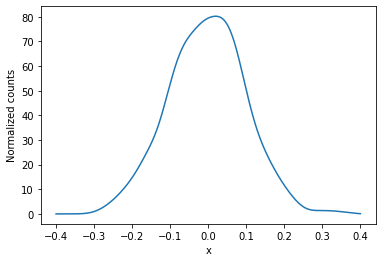

In [5]:
from scipy.integrate import trapz

som = np.sum(f, axis=0)

bin_width = bins[1] - bins[0]
int_hist = bin_width * sum(n[:])

int_dist = trapz(som, t)
plt.plot(t,som*int_hist/int_dist)
plt.xlabel("x")
plt.ylabel("Normalized counts")
plt.show()

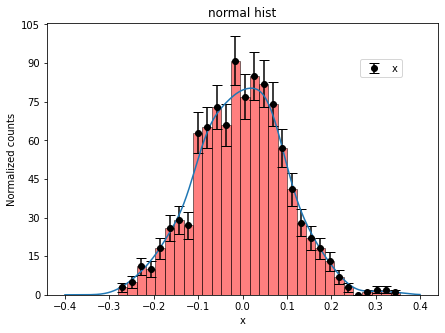

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
n, bins, _ = plt.hist(x, 30, alpha=0.5, ec='black', color='red')
mid = 0.5*(bins[1:] + bins[:-1])
ax.errorbar(mid, n, yerr=np.sqrt(n), fmt='ko', capsize=5, label='x')
#ax.hist(s, bins=30, label='x')
ax.set_ylabel('number of counts')
ax.legend(loc=(0.8, 0.8))
ax.set_title('normal hist')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(t,som*int_hist/int_dist)
plt.xlabel("x")
plt.ylabel("Normalized counts")
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 15:07:54--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-17 15:07:54--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucf16eb16b483eb7e74ced894a17.dl.dropboxusercontent.com/cd/0/inline/BDUBxXmU3nczHEMpCUPPw266kZWZA_kusMaJGnU6FZQmpg2DeplD3bU3vlcGQNbzfEN-XhYY8fhAgchucXiEAmQ9Z2xOw1aDPDmynEwt8EZTkQ/file# [segue]
--2020-11-17 15:07:55--  https://ucf16eb16b483eb7e74ced894a17.dl.dropboxusercontent.com/cd/0/inline/BDUBxXmU3nczHEMpCUPPw266kZWZA_kusMaJGnU6FZQmpg2De

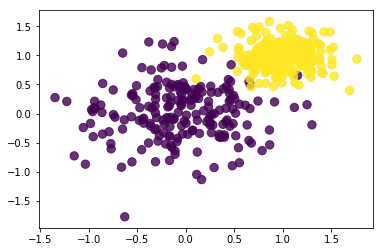

In [35]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

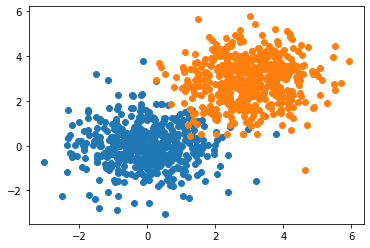

In [9]:
x1 = np.random.normal(0, 1, 500)
x2 = np.random.normal(0, 1, 500)
y1 = np.random.normal(3, 1, 500)
y2 = np.random.normal(3, 1, 500)

plt.scatter(x1, x2)
plt.scatter(y1, y2)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [51]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2020-11-17 15:24:18--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [segue]
--2020-11-17 15:24:18--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc7e12940b608d362b61639876c0.dl.dropboxusercontent.com/cd/0/inline/BDWUEwNThKsmKqR56MObxG1ZA8DqI29eH_Yr2BHpY1WBn0cTy7aLOv6ZPGLz0O7Avs4FEtrnbN5WmVsAlNR99Mya8Po7MuDXTEO5eHEZhBoy3A/file# [segue]
--2020-11-17 15:24:19--  https://uc7e12940b608d362b61639876c0.dl.dropboxusercontent.com/cd/0/inline/BDWUEwNThKsmKqR56MObxG1ZA8DqI29eH_Yr2BHpY1WBn0cTy7aLOv6ZPGLz0O7Avs4FEtrnbN5WmVsAlNR99Mya8Po

In [13]:
import pandas as pd

data = pd.DataFrame(np.load('residuals_261.npy', allow_pickle=True)).item())
data

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [14]:
data1 = data[np.abs(data['residuals'])<2]
data1

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [67]:
import scipy as sp

res = data1['residuals'].to_numpy()
dist = data1['distances'].to_numpy()

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(res, dist)

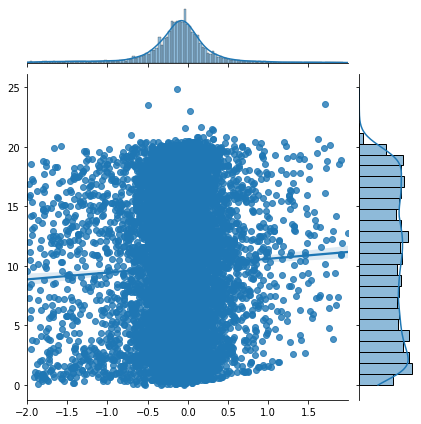

In [73]:
import seaborn as sns

sns.jointplot(x=res, y=dist, kind='reg') #, data=df)

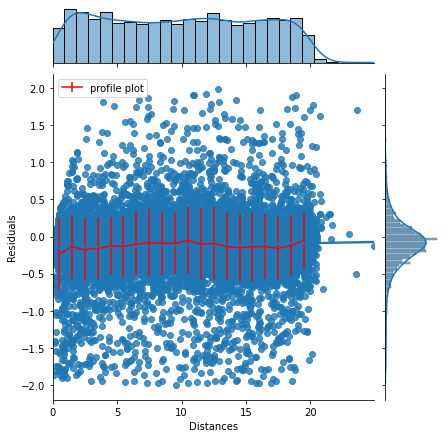

In [80]:
x_edge = np.linspace(0, 20, 21)
x = (x_edge[1:] + x_edge[:-1])/2

y = np.zeros(20)
erry = np.zeros(20)

for x_inf, x_sup, i in zip(x_edge[:-1], x_edge[1:], range(20)):
    y_slice = res[(dist>=x_inf) & (dist<=x_sup)]
    y[i] = np.mean(y_slice)
    erry[i] = np.std(y_slice)


a = sns.jointplot(x=dist, y=res, kind='reg') #, data=data1)
#a = sns.jointplot(x="distances", y="residuals", data=data1, kind='reg')
plt.errorbar(x, y, yerr=erry, label='profile plot', color='r')
plt.xlabel('Distances')
plt.ylabel('Residuals')
a.ax_joint.legend()